# AIS Examples

This example uses AIS data to show how to read and write information using PyMEOS.
It is divided in 3 sections, each corresponding to one MEOS example:
- [Reading from File](https://libmeos.org/tutorialprograms/meos_read_ais/)
- [Assembling Trips](https://libmeos.org/tutorialprograms/meos_assemble_ais/)
- [Storing in MobilityDB](https://libmeos.org/tutorialprograms/meos_store_ais/)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pymeos import *

pymeos_initialize()

## Reading from File ([MEOS Example](https://libmeos.org/tutorialprograms/meos_read_ais/))
In this section, AIS data is read from a CSV file. We then use the read information to recreate the trajectories of the ships.



First, let's read the CSV file using pandas.

In [2]:
ais = pd.read_csv('./data/aisinput.csv')
ais.head()

,t,mmsi,latitude,longitude,sog
0,2021-01-08 00:00:00,265513270,57.05900,12.272388,0.0
1,2021-01-08 00:00:01,219027804,55.94244,11.866278,0.0
2,2021-01-08 00:00:01,265513270,57.05900,12.272388,0.0
3,2021-01-08 00:00:03,219027804,55.94244,11.866278,0.0
4,2021-01-08 00:00:04,265513270,57.05900,12.272388,0.0


Now, we will create the PyMEOS object representing the position and the SOG.

In [3]:
ais['point'] = ais.apply(lambda row: TGeogPointInst(point=(row['latitude'], row['longitude']), timestamp=row['t']),
                         axis=1)
ais['sog'] = ais.apply(lambda row: TFloatInst(value=row['sog'], timestamp=row['t']), axis=1)
ais.drop(['latitude', 'longitude'], axis=1, inplace=True)
ais.head()

,t,mmsi,sog,point
0,2021-01-08 00:00:00,265513270,0@2021-01-08 00:00:00+01,0101000020E6100000643BDF4F8D874C404CA59F70768B...
1,2021-01-08 00:00:01,219027804,0@2021-01-08 00:00:01+01,0101000020E61000009B38B9DFA1F84B40137D3ECA88BB...
2,2021-01-08 00:00:01,265513270,0@2021-01-08 00:00:01+01,0101000020E6100000643BDF4F8D874C404CA59F70768B...
3,2021-01-08 00:00:03,219027804,0@2021-01-08 00:00:03+01,0101000020E61000009B38B9DFA1F84B40137D3ECA88BB...
4,2021-01-08 00:00:04,265513270,0@2021-01-08 00:00:04+01,0101000020E6100000643BDF4F8D874C404CA59F70768B...


## Assembling Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_assemble_ais/))

Now, we will create the trajectory (TGeogPointSeq) and the SOG evolution (TFloatSeq) for every ship (identified by the mmsi) using the instants we have created.

In [4]:
trajectories = ais.groupby('mmsi').aggregate(
    {
        'point': TGeogPointSeq.from_instants,
        'sog': TFloatSeq.from_instants
    }
).rename({'point': 'trajectory'}, axis=1)
trajectories['distance'] = trajectories['trajectory'].apply(lambda t: t.length())
trajectories.head()

,trajectory,sog,distance
mmsi,,,
219001559,[0101000020E6100000191C25AFCECB4C400BB6114F76F...,"[0@2021-01-08 00:00:05+01, 0@2021-01-08 23:59:...",6630.891373
219027804,[0101000020E61000009B38B9DFA1F84B40137D3ECA88B...,"[0@2021-01-08 00:00:01+01, 0@2021-01-08 10:04:...",91682.890440
257136000,[0101000020E610000023A0C211A4744C405320B3B3E87...,"[14@2021-01-08 00:02:57+01, 13@2021-01-08 00:0...",940353.810230
265513270,[0101000020E6100000643BDF4F8D874C404CA59F70768...,"[0@2021-01-08 00:00:00+01, 0@2021-01-08 23:59:...",15.752920
566948000,[0101000020E61000003332C85D84C94B405E83BEF4F67...,"[0@2021-01-08 00:00:04+01, 0@2021-01-08 16:40:...",21156.229886


Here we can see that PyMEOS has been able to greatly reduce the number of points stored (and thus memory used) without losing any information.

In [5]:
pd.concat([ais.groupby('mmsi')['t'].count().rename('original #points'),
           trajectories['trajectory'].apply(lambda t: t.num_instants).rename('PyMEOS #points')],
          axis=1)

,original #points,PyMEOS #points
mmsi,,
219001559,48323,1598
219027804,38326,3288
257136000,21770,14815
265513270,21799,6
566948000,26619,2980


We can visualize the trajectories and the SOG evolutions by plotting them.

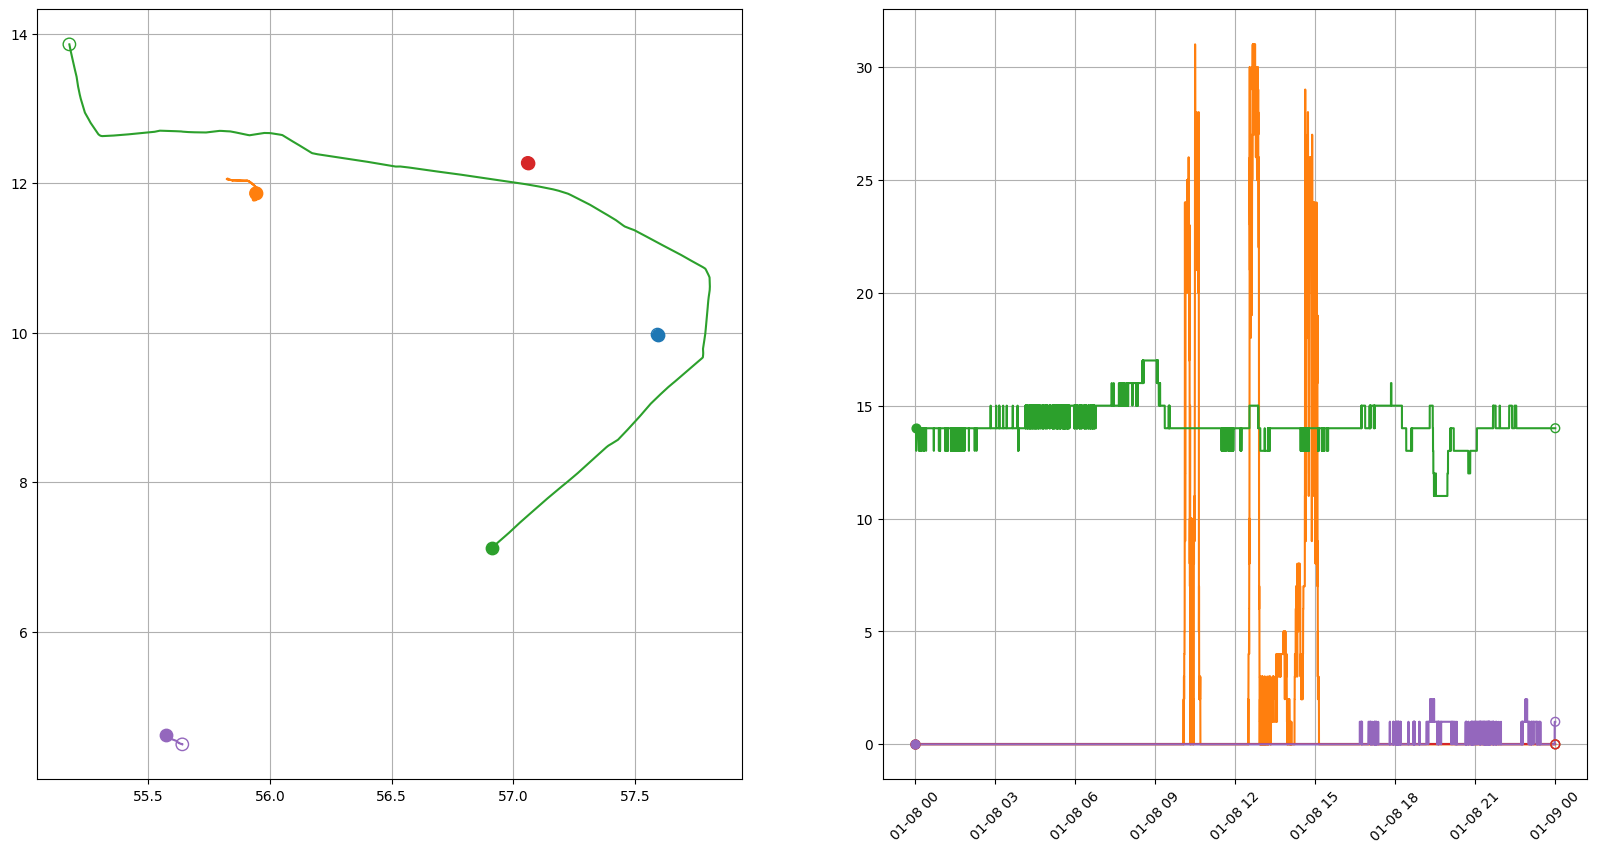

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for _, ship in trajectories.iterrows():
    ship['trajectory'].plot(axes=axes[0])
    ship['sog'].plot(axes=axes[1])
plt.show()

# Storing in MobilityDB ([MEOS Example](https://libmeos.org/tutorialprograms/meos_store_ais/))

Now we will store the temporal objects we have created in MobilityDB.
To connect to MobilityDB (PostgreSQL), `psycopg2` is used. You can install it yourself or install `pymeos` with the `db` option:
```shell
pip install pymeos[db]
```
If you don't have MobilityDB set up, you can use the Docker image to quickly start:
```shell
docker run -d -p 5432:5432 --name pymeos-demo-db mobilitydb/mobilitydb:14-3.2-develop
```

First, set up the connection parameters. Change any of the following values according to your configuration

In [7]:
from pymeos.db import MobilityDB

host = 'localhost'
port = 5432
db = 'mobilitydb'
user = 'docker'
password = 'docker'

connection = MobilityDB.connect(host=host, port=port, database=db, user=user, password=password)
cursor = connection.cursor()

Now, we will create the table where we will write our objects.

In [8]:
cursor.execute("DROP TABLE IF EXISTS public.PyMEOS_demo;")
cursor.execute("CREATE TABLE public.PyMEOS_demo"
               "(MMSI integer, trajectory public.tgeogpoint, SOG public.tfloat);")
connection.commit()

Let's insert now the rows of the DataFrame into the MobilityDB table

In [9]:
for mmsi, row in trajectories.iterrows():
    cursor.execute(f"INSERT INTO public.PyMEOS_demo(MMSI, trajectory, SOG) "
                   f"VALUES ({mmsi}, '{row.trajectory}', '{row.sog}');")
connection.commit()

Now, we will read one of the records that we just wrote

In [10]:
cursor.execute("SELECT * FROM public.PyMEOS_demo WHERE MMSI = 257136000;")
mmsi, trajectory, sog = cursor.fetchone()

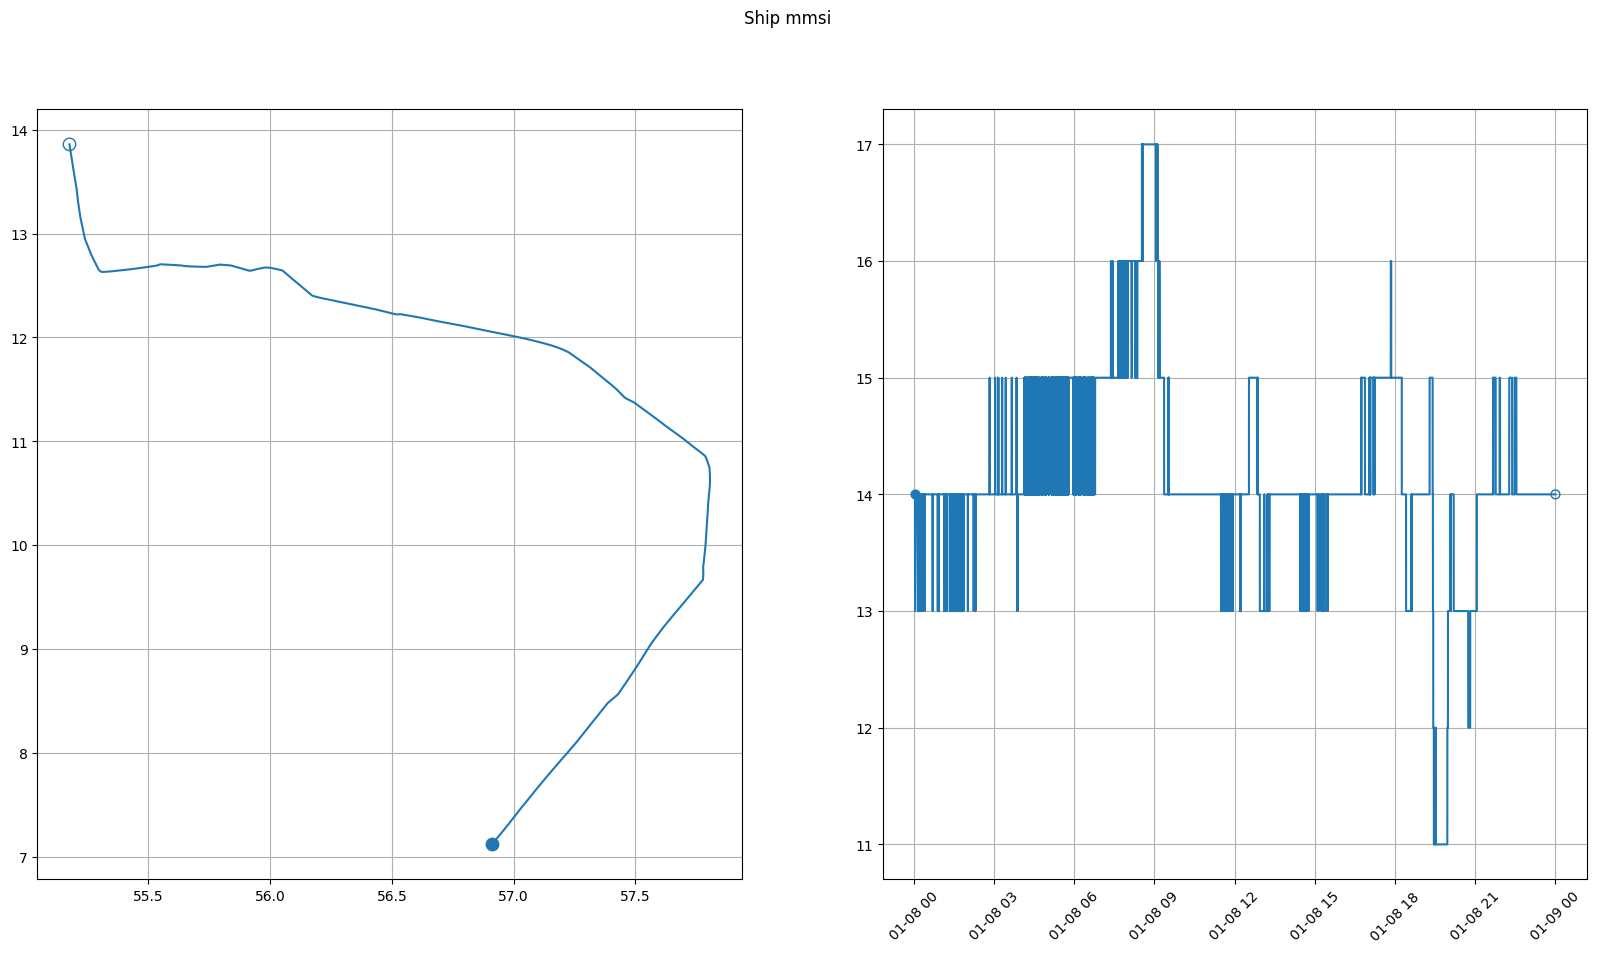

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
trajectory.plot(axes=axes[0])
sog.plot(axes=axes[1])
plt.suptitle(f'Ship mmsi')
plt.show()

Finally, let's close the connection and wrap everything up

In [12]:
connection.commit()
cursor.close()
pymeos_finalize()